This notebook is from: [Nicolás Coca-López: Data Science for Raman Spectroscopy Notebook](https://github.com/nicocopez/Data-Science-for-Raman-spectroscopy-a-practical-example/blob/main/Workshop%20ML%20with%20Python%20-%20DS%20for%20Raman%20spectroscopy%20-%20An%20example%20by%20NCL.ipynb)

In [18]:
import numpy as np
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from Preprocessing.preprocess import modified_z_score, fixer, baseline_als
import sklearn.linear_model as linear_model

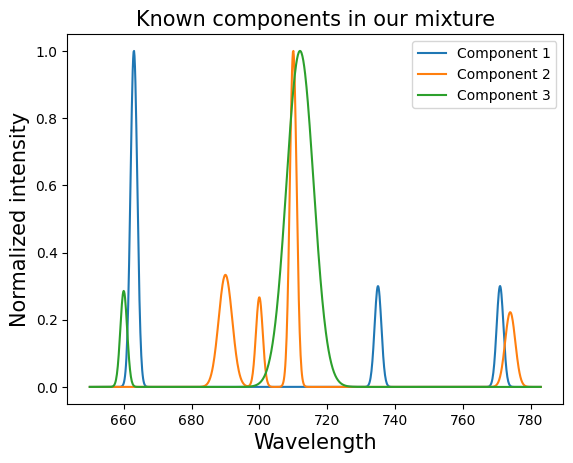

In [19]:

def Gauss(x, mu, sigma, A=1):
    return A * np.exp(-(x - mu) ** 2 / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

x_range = np.linspace(650, 783, 1000)
# First component
mu_a1 = 663
sigma_a1 = 1
intensity_a1 = 1

mu_a2 = 735
sigma_a2 = 1
intensity_a2 = 0.3

mu_a3 = 771
sigma_a3 = 1
intensity_a3 = 0.3

gauss_a = Gauss(x_range, mu_a1, sigma_a1, intensity_a1) + Gauss(x_range, mu_a2, sigma_a2, intensity_a2) + Gauss(x_range, mu_a3, sigma_a3, intensity_a3)

# Second component
mu_b1 = 700
sigma_b1 = 1
intensity_b1 = 0.2

mu_b2 = 690
sigma_b2 = 2
intensity_b2 = 0.5

mu_b3 = 710
sigma_b3 = 1
intensity_b3 = 0.75

mu_b4 = 774
sigma_b4 = 1.5
intensity_b4 = 0.25

gauss_b = Gauss(x_range, mu_b1, sigma_b1, intensity_b1) + Gauss(x_range, mu_b2, sigma_b2, intensity_b2) + Gauss(x_range, mu_b3, sigma_b3, intensity_b3) + Gauss(x_range, mu_b4, sigma_b4, intensity_b4)

# Third component
mu_c1 = 660
sigma_c1 = 1
intensity_c1 = 0.05

mu_c2 = 712
sigma_c2 = 4
intensity_c2 = 0.7

gauss_c = Gauss(x_range, mu_c1, sigma_c1, intensity_c1) + Gauss(x_range, mu_c2, sigma_c2, intensity_c2)

# Normalization
component_a = gauss_a / np.max(gauss_a)
component_b = gauss_b / np.max(gauss_b)
component_c = gauss_c / np.max(gauss_c)


plt.plot(x_range, component_a, label = 'Component 1')
plt.plot(x_range, component_b, label = 'Component 2')
plt.plot(x_range, component_c, label = 'Component 3')
plt.title('Known components in our mixture', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Normalized intensity', fontsize = 15)
plt.legend()
plt.show()

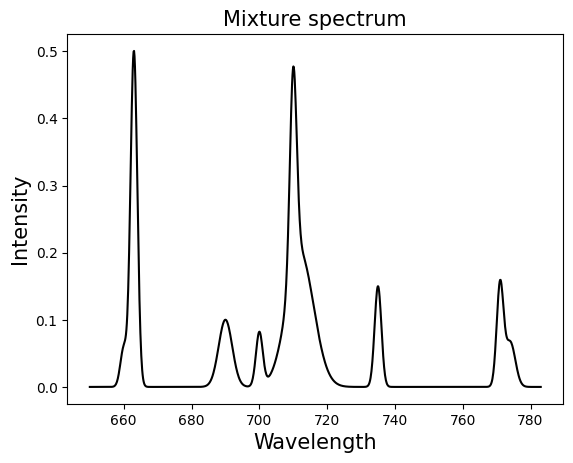

In [20]:
# What concentrations we want these components to have in our mixture:
c_a = 0.5
c_b = 0.3
c_c = 0.2

comps = np.array([c_a, c_b, c_c])

# Let's build the spectrum to be studied: The mixture spectrum
mix_spectrum = c_a * component_a + c_b * component_b + c_c *component_c

# How does it look?
plt.plot(x_range, mix_spectrum, color = 'black', label = 'Mixture spectrum with noise')
plt.title('Mixture spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

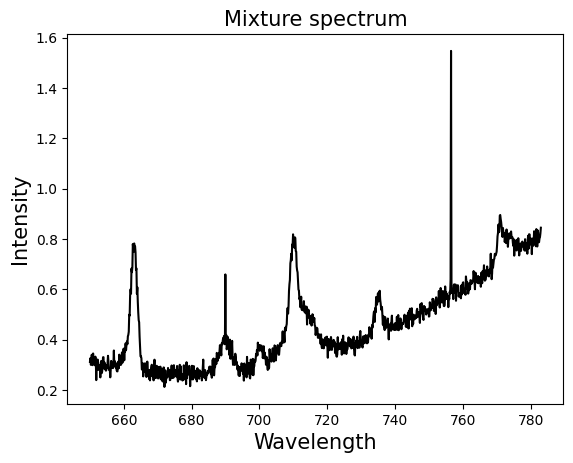

In [21]:
# Let's add some noise for a bit of realism:

# Random noise:
mix_spectrum = mix_spectrum +  np.random.normal(0, 0.02, len(x_range))

# Spikes: 
mix_spectrum[800] = mix_spectrum[800] + 1
mix_spectrum[300] = mix_spectrum[300] + 0.3

# Baseline as a polynomial background:
poly = 0.2 * np.ones(len(x_range)) + 0.0001 * x_range + 0.000051 * (x_range - 680)**2 
mix_spectrum = mix_spectrum + poly

# How does it look now?
plt.plot(x_range, mix_spectrum, color = 'black', label = 'Mixture spectrum with noise')
plt.title('Mixture spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

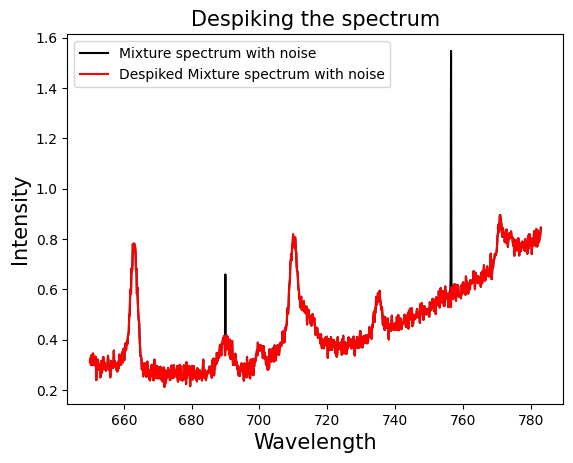

In [22]:
despiked_spectrum = fixer(mix_spectrum,ma=10)

plt.plot(x_range, mix_spectrum, color = 'black', label = 'Mixture spectrum with noise')
plt.plot(x_range, despiked_spectrum, color = 'red', label = 'Despiked Mixture spectrum with noise')
plt.title('Despiking the spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.legend()
plt.show()

In [23]:
# Parameters for this case:
l = 10000000 # smoothness
p = 0.05 # asymmetry

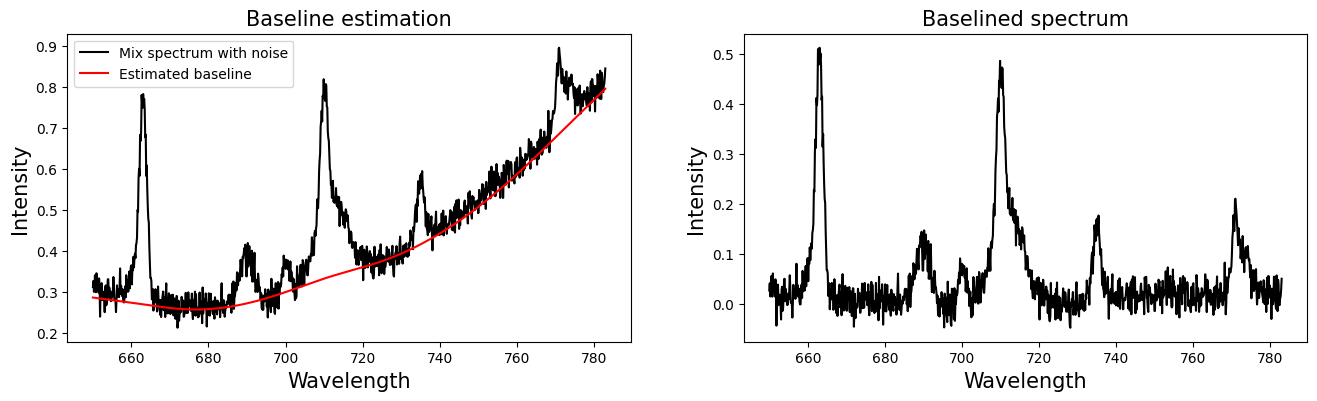

In [24]:
# Estimation of the baseline:
estimated_baselined = baseline_als(despiked_spectrum, l, p)

# Baseline subtraction:
baselined_spectrum = despiked_spectrum - estimated_baselined

# How does it look like?
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))

# We compared the original mix spectrum and the estimated baseline:
ax1.plot(x_range, despiked_spectrum, color = 'black', label = 'Mix spectrum with noise' )
ax1.plot(x_range, estimated_baselined, color = 'red', label = 'Estimated baseline')
ax1.set_title('Baseline estimation', fontsize = 15)
ax1.set_xlabel('Wavelength', fontsize = 15)
ax1.set_ylabel('Intensity',  fontsize = 15)
ax1.legend()

# We plot the mix spectrum after baseline subtraction
ax2.plot(x_range, baselined_spectrum, color = 'black', label = 'Baselined spectrum with noise' )
ax2.set_title('Baselined spectrum', fontsize = 15)
ax2.set_xlabel('Wavelength', fontsize = 15)
ax2.set_ylabel('Intensity',  fontsize = 15)
plt.show()


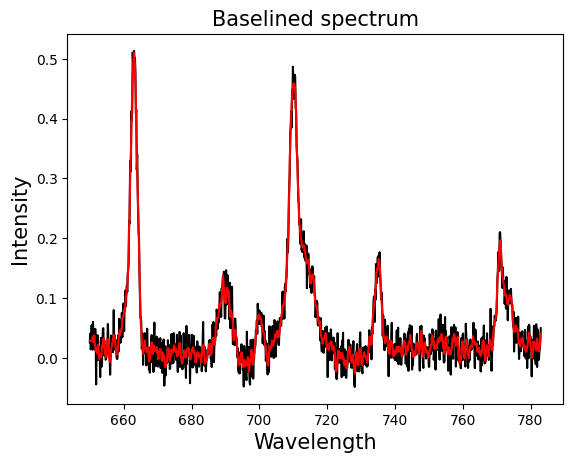

In [25]:
# Parameters:
w = 9 # window (number of points)
p = 2 # polynomial order

smoothed_spectrum = savgol_filter(baselined_spectrum, w, polyorder = p, deriv=0)

# Some more information on the implementation of this method can be found here:
# https://nirpyresearch.com/savitzky-golay-smoothing-method/


# We plot the mix spectrum after baseline subtraction
plt.plot(x_range, baselined_spectrum, color = 'black', label = 'Baselined spectrum with noise' )
plt.plot(x_range, smoothed_spectrum, color = 'red', label = 'Baselined spectrum with noise' )
plt.title('Baselined spectrum', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity',  fontsize = 15)
plt.show()

In [26]:
query_spectrum = smoothed_spectrum # Let's just rename it

In [27]:
# Generate the components matrix or K matrix
components = np.array([component_a, component_b, component_c])  

In [28]:
cs = linear_model.LinearRegression().fit(components.T, query_spectrum).coef_
#We print the result:
print('The expected concentrations for components A, B and C are: ' + str(cs))  

The expected concentrations for components A, B and C are: [0.49840061 0.30361184 0.16848612]


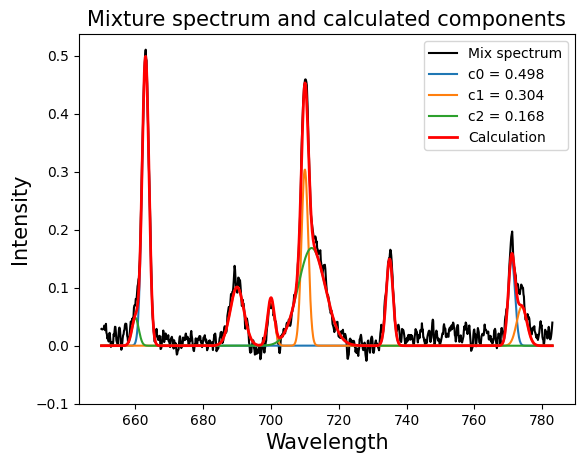

In [29]:
# Does the result match the original data?

# Plot the original data:
plt.plot(x_range, query_spectrum, color = 'black', label = 'Mix spectrum' )

# Plot the separate components times its calculated concentration:
for i in np.arange(len(cs)):
    plt.plot(x_range, cs[i]*components[i], label = 'c' + str(i)+ ' = ' + str(np.round(cs[i], 3)))

# Plot the result: the sum of separate components times its calculated concentration:
plt.plot(x_range, np.dot(cs,components), color = 'red', linewidth = 2, label = 'Calculation')
    
plt.title('Mixture spectrum and calculated components', fontsize = 15)
plt.xlabel('Wavelength', fontsize = 15)
plt.ylabel('Intensity', fontsize = 15)
plt.legend()
plt.ylim(ymin = -0.1)
plt.show()